# import function

In [2]:
from warnings import warn

import numpy as np
import pandas as pd

import GRIN_analysis_tools as ga
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools as it
from sklearn.preprocessing import minmax_scale, scale
from sklearn.preprocessing import normalize
%matplotlib inline
#%matplotlib qt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# export_path = '/Volumes/lab-kohlj/home/shared/projects/pregnancy_2021/Figure_4/linked_figure_4/' 
export_path = 'output_figures/' 

# LDA analysis

## LDA functions

In [13]:
def confidence_ellipse(x, y, ax, facecolor, n_std=2.0, **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse((0, 0),
                                    width=ell_radius_x * 2,
                                    height=ell_radius_y * 2,
                                    facecolor=facecolor,
                                    alpha = 0.3,
                                    **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = mpl.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return mean_x, mean_y
    
def centroid_distance(css, centroids, ID, state):
    
    centroid = {}
    centroid['ID'] = [ID]
    centroid['State'] = [state] 
    
    ds = euclidean_distances(css)

    bol = np.tril(np.ones(ds.shape))
    np.fill_diagonal(bol, 0)

    ds = ds[bol.astype(bool)]
    #ds = normalize([ds])[0]

    for i in range(len(ds)):
        centroid[centroids.columns.tolist()[i+2]] = ds[i]

    centroid = pd.DataFrame(centroid)
    centroids = pd.concat([centroids, centroid])
    return centroids

## import and parameter setting

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn import preprocessing
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split, LeaveOneOut,cross_val_score
from sklearn import metrics
from sklearn import datasets
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

## dataset organisation

# original

In [6]:
bhv_episodes = pd.DataFrame(columns = ['IDs', 'State', 'Behav', 'Cell', 'Activities'])
path = 'dataset/'
names = np.array([])
IDs = ['JKAA40.3e', 'JKAA40.4i', 'JKAA40.4h','JKAA40.5d', 'JKAA44.2i']
states = ['virgin', 'PD18', 'PD50']
num_episodes = {'pup sniff':1,
                'male intruder contact':1,
                'female intruder contact':1,
                'food pellet contact':1,
                'screw contact':1,
                'dummy pup contact':1 }
behavs = list(num_episodes.keys())
# num_episodes = {'pup sniff':1,
#                 'male intruder contact':1,
#                 'female intruder contact':1,
#                 'food pellet contact':1,
#                 'screw contact':1, 
#                'dummy pup contact':1}

fr = 20
window = 3
convolve = 'non_convolved'

for ID in IDs:
    
    for state in states:

        # Import calcium traces
        try:
            df = ga.load_inscopix(path + f'{ID}/{convolve}/{ID}_registered_{state}'+'.csv', normalisation='fixed interval')

        except FileNotFoundError:
            warn(f'Inscopix file for {ID}_{state} not found')
            continue

        # Import behaviour
        try:

            _, bdf, _ = ga.preprocess_behaviour(path + f'{ID}/{ID}_behav_{state}_post.csv', df.shape[1])

        except FileNotFoundError:
            warn(f'Behaviour file for {ID}_{state} not found')
            
            continue
        
        # making sure the cell number responding to each sensory stimuli is the same (
        # comment below if use all neurons
        try:
            for behav in behavs:
                test = bdf.loc[:,behav]
                
        except KeyError:
            pass
        
        for behav in behavs:
            bhv_episode = {}
            # Extract behaviour episodes
            try:
                episodes = ga.extract_behav_episodes(df, bdf, behav, fr = fr, window = window)
            # Extract certain numbers of episodes
            
                if num_episodes is not None:
                    sample = num_episodes[behav]
                    episodes = episodes[:sample]
                    
                    if episodes.shape[0] < sample:
                        warn(f'Not enough {behav} episodes in {ID}')
                        continue

            except KeyError:
                warn(f"Behaviour '{behav}' is not present in recording {ID}_{state}")
                
                continue
            #episodes = ga.behaviour_episode_zscore(episodes, baseline_interval)
            episodes = np.nan_to_num(episodes)
            
        # extract only the activity period (ignore the baseline)
            episodes = episodes[:,:,-window*fr:]
  
            bhv_episode['IDs']  = [ID]
            bhv_episode['State'] = [state]
            bhv_episode['Behav'] = [behav]
            bhv_episode['Activities'] = [episodes]
            bhv_episode = pd.DataFrame(bhv_episode)
            bhv_episodes = pd.concat([bhv_episodes, bhv_episode])

        
        names = np.append(names, f'{ID}_{state}')

In [7]:
bhv_episodes

,IDs,State,Behav,Cell,Activities
0,JKAA40.3e,virgin,pup sniff,NaN,"[[[0.18615722083574332, 0.175331149384282, 0.1..."
0,JKAA40.3e,virgin,food pellet contact,NaN,"[[[0.08752644763476009, 0.09498579343165348, 0..."
0,JKAA40.3e,virgin,screw contact,NaN,"[[[0.12685344906918816, 0.13127619717440253, 0..."
0,JKAA40.3e,virgin,dummy pup contact,NaN,"[[[0.10436727154393098, 0.0984873760800471, 0...."
0,JKAA40.3e,PD18,pup sniff,NaN,"[[[0.6139249386971211, 0.5894288821501568, 0.6..."
...,...,...,...,...,...
0,JKAA44.2i,PD50,male intruder contact,NaN,"[[[0.35705199397302556, 0.42165658000971407, 0..."
0,JKAA44.2i,PD50,female intruder contact,NaN,"[[[0.2854610708920089, 0.2986188663442167, 0.2..."
0,JKAA44.2i,PD50,food pellet contact,NaN,"[[[0.36648343852871296, 0.3670863444708189, 0...."
0,JKAA44.2i,PD50,screw contact,NaN,"[[[0.7399938959806801, 0.7625722146787964, 0.8..."


In [8]:
bhv_episodes = bhv_episodes.explode('Activities')
bhv_episodes = bhv_episodes.explode('Activities')
bhv_episodes = bhv_episodes.reset_index()

In [9]:
columns = np.arange(fr*window).tolist()
#converting column head to string
for i in range(len(columns)):
    columns[i] = str(columns[i])

#releasing activities to column
df = pd.DataFrame(bhv_episodes['Activities'].to_list(), columns=columns)
dfs = pd.concat([bhv_episodes, df], axis = 1)
dfs = dfs.drop(columns = ['index', 'Activities'])

In [10]:
# assign cell number
for ID in IDs:
    
    for state in states:
        
        for behav in dfs.Behav.unique():
            df = dfs[(dfs.IDs == ID) &
                    (dfs.State == state) &
                    (dfs.Behav == behav)]
            
            dfs.loc[(dfs.IDs == ID) &
                    (dfs.State == state) &
                    (dfs.Behav == behav), 'Cell'] = np.arange(df.shape[0])

## Cross validated version

In [11]:
sns.set(rc={"figure.figsize": (2.5, 2.5)}) #3,3
sns.set(font_scale=2) 
sns.set_style("ticks")
behavs = list(num_episodes.keys())
colors = ['#df65b0', 'green', 'Tab:orange', 'gray']

ls = ['pup sniff', 'intruder contact', 'food pellet contact', 'object contact']

columns = ['IDs','State']
combo = [str(l) for l in itertools.combinations(ls, 2)]
columns.extend(combo)
centroids = pd.DataFrame(columns = columns)
plotting_c = True
combos = list(list(l) for l in itertools.combinations(ls, 2))

scores =  pd.DataFrame(columns = columns[:5])
trains = pd.DataFrame(columns = ['IDs', 'State','Behav'])
tests = pd.DataFrame(columns = ['IDs', 'State','Behav'])



for ID in IDs:
    for state in states:
        for behaviour in dfs.Behav.unique():
        
            df = dfs[(dfs.IDs == ID) &
                    (dfs.State == state)&
                    (dfs.Behav == behaviour)]
            
            # split train and test dataset -train dataset: first sniff episode, test dataset: later sniff episode
            train = df.iloc[:int(df.shape[0]/2),:]
            test = df.iloc[-int(df.shape[0]/2):,:]
            
            trains = pd.concat([trains,train])
            tests = pd.concat([tests,test])
            
        

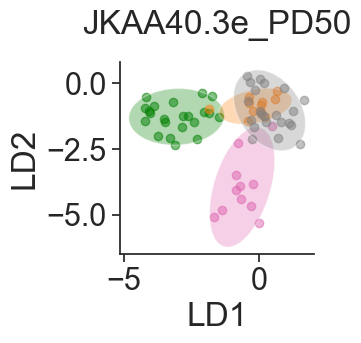

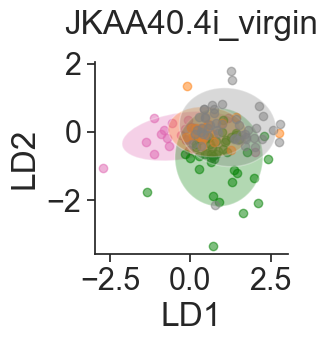

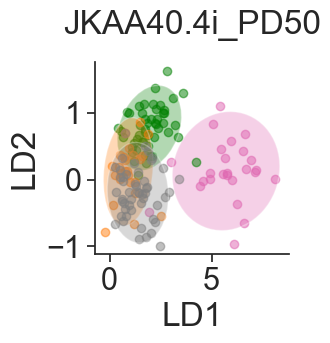

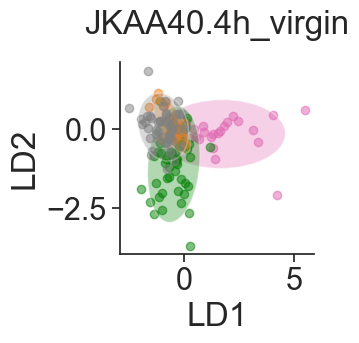

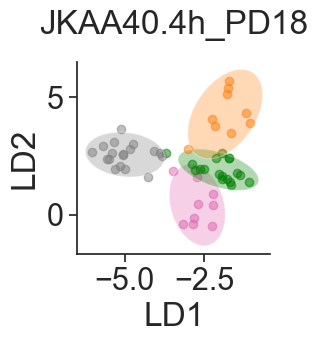

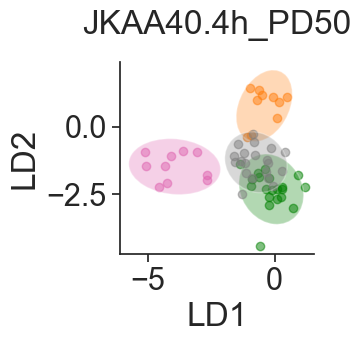

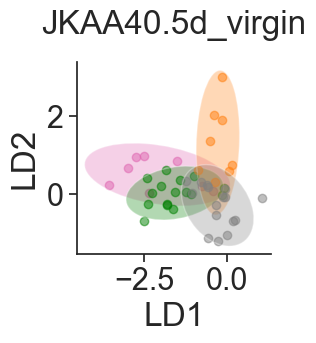

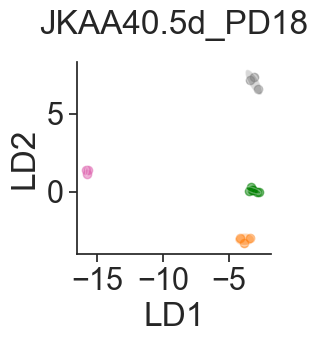

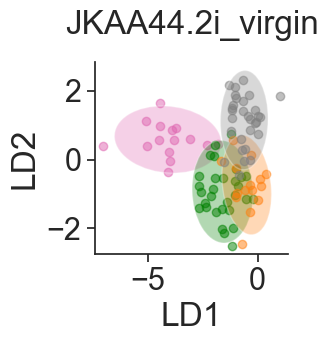

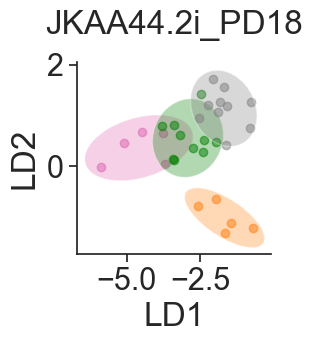

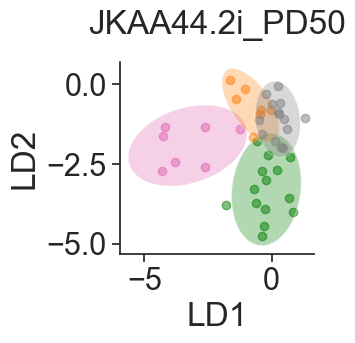

In [14]:
for ID in IDs:
    for state in states:
        train = trains[(trains.IDs == ID) &
                        (trains.State == state)]
        
        test = tests[(tests.IDs == ID) &
                        (tests.State == state)]
        
        #define predictor and response variables
        X_train = train.iloc[:,4:]
        X_test = test.iloc[:,4:]
       
        y_train = train['Behav']
        y_test = test['Behav']
        
        
        # regroup intruder contact vs object contact
        y_train.loc[y_train.isin(['male intruder contact', 'female intruder contact'])] = 'intruder contact'
        y_train.loc[y_train.isin(['dummy pup contact', 'screw contact'])] = 'object contact'
        y_test.loc[y_test.isin(['male intruder contact', 'female intruder contact'])] = 'intruder contact'
        y_test.loc[y_test.isin(['dummy pup contact', 'screw contact'])] = 'object contact'
        
       
        if len(y_train.unique()) <4:
            continue
        else:
    
        
            #Fit the LDA model
            lda = LinearDiscriminantAnalysis(shrinkage = 0.05, solver = 'eigen')
            # X_t = lda.fit(X, y).transform(X)
            X_t = lda.fit(X_test, y_test).transform(X_test)
            
            
            # plotting and centroids visualisation
            if plotting_c:
                css =[]
                for color, i, behav in zip(colors, ls, behavs):
                    # fig = plt.scatter(X_t[y == i, 0], X_t[y == i, 1], c=color, label=behav, alpha = 0.5)
                    
                    fig = plt.scatter(X_t[y_test == i, 0], X_t[y_test == i, 1], c=color, label=behav, alpha = 0.5)

                    ax = plt.gca()

                    # cs = confidence_ellipse(X_t[y == i, 0], X_t[y == i, 1], ax, facecolor = color)
                    cs = confidence_ellipse(X_t[y_test == i, 0], X_t[y_test == i, 1], ax, facecolor = color)
                    css.append(cs)

                plt.title(ID + '_' + state, pad=20)
                ax.set_xlabel('LD1')
                ax.set_ylabel('LD2')
                # plt.ylim(-5,5)
                # plt.xlim(-8,6)
                # plt.savefig(export_path + ID + '_' + state + '.pdf', dpi=300, transparent= False, bbox_inches = "tight")
                plt.show()

                # # get centroids of the ellipses and store them in a dataframe
                centroids = centroid_distance(css,centroids, ID, state)
                
            score = {}
            for column, c in zip(columns[2:], combos):
                if c[0] == 'pup sniff':
                    try:
                        X_all = X_test[y_test.isin(c)]
                        y_all = y_test[y_test.isin(c)]
                        y_pred = lda.predict(X_all)
                        rand = metrics.rand_score(y_all, y_pred)
#                         X_all = X_test[y_test.isin(c)]
#                         y_all = y_test[y_test.isin(c)]
#                         y_pred = lda.predict(X_all)
#                         rand = metrics.rand_score(y_all, y_pred)
                        
                        
                        score['IDs'] = [ID]
                        score['State'] = [state]
                        score[column] = rand
                       
                    except ValueError:
                        continue
           
            score = pd.DataFrame(score)
            scores = pd.concat([scores,score])

In [15]:
scores

,IDs,State,"('pup sniff', 'intruder contact')","('pup sniff', 'food pellet contact')","('pup sniff', 'object contact')"
0,JKAA40.3e,PD50,0.965909,0.878788,0.882576
0,JKAA40.4i,virgin,0.652174,0.567150,0.705456
0,JKAA40.4i,PD50,0.858739,0.804082,0.815856
0,JKAA40.4h,virgin,0.682316,0.749113,0.806338
0,JKAA40.4h,PD18,0.857550,0.843137,0.905983
0,JKAA40.4h,PD50,0.956322,1.000000,0.914943
0,JKAA40.5d,virgin,0.728261,0.658333,0.728261
0,JKAA40.5d,PD18,1.000000,1.000000,1.000000
0,JKAA44.2i,virgin,0.859596,0.937931,0.885859
0,JKAA44.2i,PD18,0.914286,1.000000,1.000000


## discriminability measurement

### compute distance between clusters in the form of true positive

In [16]:
stacked = scores.iloc[:,2:].stack().reset_index()
stacked = stacked.drop(columns = ['level_0'])
stacked = stacked.rename(columns = {'level_1':'behaviour_combo', 0:'Rand_index'})
repeat = scores.reset_index()
repeat = repeat.loc[repeat.index.repeat(3)] #6 for first sniff, 3 for 2nd sniff
repeat = repeat.reset_index()

tp_plot =  pd.concat([repeat.iloc[:,:4], stacked], axis = 1)
tp_plot = tp_plot.drop(columns = ['level_0', 'index'])
tp_plot.State = pd.Categorical(tp_plot.State, 
                              categories=states,
                              ordered=True)
tp_plot.behaviour_combo = pd.Categorical(tp_plot.behaviour_combo, 
                                      categories=combo,
                                      ordered=True)
tp_plot.sort_values(['State', 'behaviour_combo'], inplace=True)


tp_plot.to_csv('generated_dataset/discriminability.csv')

In [17]:
# paired statistics for cluster separation
for i in scores.columns[2:]:
    p = stats.ttest_ind(scores[scores['State'] == 'PD18'][:][i],
                       scores[scores['State'] == 'virgin'][i])
    print(i, p)

('pup sniff', 'intruder contact') TtestResult(statistic=3.0081954624062632, pvalue=0.029817294235395767, df=5.0)
('pup sniff', 'food pellet contact') TtestResult(statistic=2.1235447875609945, pvalue=0.08711345399112205, df=5.0)
('pup sniff', 'object contact') TtestResult(statistic=3.3974962683965133, pvalue=0.019303445917278166, df=5.0)


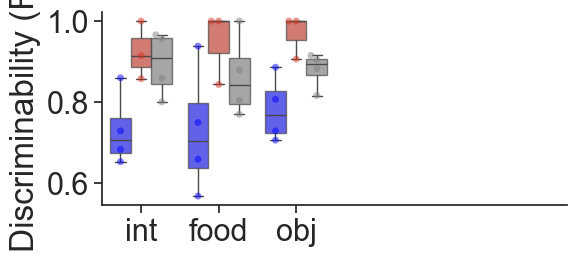

In [19]:
plt.subplots(figsize = [6,2.5])
sns.set(font_scale=2) 
sns.set_style("ticks")
x = sns.swarmplot(x = 'behaviour_combo', y = 'Rand_index', hue = 'State', data = tp_plot, dodge = True, 
                  palette = ['#0000ff', '#d7301f','#808080'], alpha=.5)
x = sns.boxplot(x = 'behaviour_combo', y = 'Rand_index', hue = 'State', data = tp_plot,  palette = ['#0000ff', '#d7301f','#808080'], 
                boxprops=dict(alpha=.7), showfliers=False)
x.get_legend().remove()

#plt.ylim(0.5,1)
sns.despine()
plt.ylabel('Discriminability (RI)')
plt.xlabel('')
plt.xticks(ticks = np.arange(3), labels = ['int', 'food', 'obj']); # labels= vs int, vs food, vs obj...
#plt.savefig(export_path + 'Rand_index.pdf', dpi=300, transparent=True, bbox_inches = "tight")
# plt.savefig(export_path + 'Rand_index.pdf', dpi=300, transparent=True, bbox_inches = "tight")